In [1]:
!module list

Currently Loaded Modulefiles:
 1) singularity   2) openmpi/4.1.5   3) NCI-data-analysis/2025.05   4) pbs  
>

In [2]:
import scipy.stats as stats
import numpy as np
import torch
import matplotlib.pyplot as plt


#import pyshtools as pysh
#pysh.utils.figstyle(rel_width=0.75)
#%config InlineBackend.figure_format = 'retina'

In [3]:
wdir = "/g/data/z00/yxs900/neuraloperators/sfno/curriculum_learning/lowRes/experiments/03_LUCIE/LUCIE_fix"
data = np.load(f"{wdir}/era5_T30_regridded.npz")
data.files

['temperature',
 'humidity',
 'u_wind',
 'v_wind',
 'surface_pressure',
 'precipitation',
 'tisr',
 'orography']

# Normalization Scalars

In [4]:
# comparing mean, std to era5, t-> t1000, q -> q1000, z->z200, u-> u200, v-> v200
for var in data.files:
    mm = data[var].mean()
    ss = data[var].std()
    print(f"{var}: mean={mm}, std={ss}")

temperature: mean=277.4626770019531, std=17.816375732421875
humidity: mean=0.006629979237914085, std=0.005532822106033564
u_wind: mean=10.695755004882812, std=15.56001091003418
v_wind: mean=-0.02342492900788784, std=12.149330139160156
surface_pressure: mean=96811.390625, std=9123.89453125
precipitation: mean=0.0006106931250542402, std=0.001604488817974925
tisr: mean=1079093.125, std=1444145.25
orography: mean=367.17120361328125, std=809.2915649414062


In [5]:
data = np.load(f"{wdir}/era5_T30_preprocessed.npz")
data_inp = data["data_inp"]     # input data 
data_tar = data["data_tar"]
raw_means = data["raw_means"]
raw_stds = data["raw_stds"]
prog_means = raw_means[:5] # this is literally zero?
prog_stds = raw_stds[:5] # this is literally zero?
diag_means = data["diag_means"]
diag_stds = data["diag_stds"]
diff_means = data["diff_means"]
diff_stds = data["diff_stds"]

In [6]:
vars = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure', 'tisr', 'orography']
list(zip(vars, raw_means, raw_stds))

[('temperature', 277.462646484375, 17.816408157348633),
 ('humidity', 0.006629981566220522, 0.005532818380743265),
 ('u_wind', 10.695756912231445, 15.56002426147461),
 ('v_wind', -0.023422522470355034, 12.14930534362793),
 ('surface_pressure', 96811.390625, 9123.8916015625),
 ('tisr', 1079094.75, 1444147.125),
 ('orography', 367.17120361328125, 809.2916259765625)]

In [7]:
# this is not comparible to dt_std_array because 
# the time difference is done before the (mean,std) normalization.
# one should compare e.g. t->t1000: 1.4138480424880981/17.816408157348633=0.07935651395059314 vs 0.06873227 
vars= ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure']
list(zip(vars, diff_means, diff_stds))

[('temperature', 9.803541615838185e-05, 1.4138480424880981),
 ('humidity', 2.0586108817610693e-08, 0.0005922476993873715),
 ('u_wind', -3.1180163205135614e-05, 4.642238140106201),
 ('v_wind', -5.063314802100649e-06, 5.960874080657959),
 ('surface_pressure', 0.0021911216899752617, 241.07797241210938)]

In [8]:
# very similar to the result shown in norm.ipynb
list(zip(vars,[ diff_stds[ii] / raw_stds[ii] for ii in range(5) ]))

[('temperature', 0.07935651395059314),
 ('humidity', 0.1070426785467356),
 ('u_wind', 0.298343888293286),
 ('v_wind', 0.4906349714705557),
 ('surface_pressure', 0.026422713348635562)]

In [9]:
# for log scale preciptation
diag_means,diag_stds

(array([0.05197881]), array([0.11017133]))

# Variable Fields

In [10]:
wdir = "/g/data/z00/yxs900/neuraloperators/sfno/curriculum_learning/lowRes/experiments/03_LUCIE/LUCIE_fix"
raw_data = np.load(f"{wdir}/era5_T30_regridded.npz")

data = np.load(f"{wdir}/era5_T30_preprocessed.npz")
data_inp = data["data_inp"]     # input data 
data_tar = data["data_tar"]

inp_vars = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure', 'tisr', 'orography']
tar_vars = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure','precipitation']
vars_to_plot = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure', 'tisr', 'orography','precipitation']

raw_data["temperature"].shape, data_inp.shape, data_tar.shape

((16538, 48, 96), (16537, 7, 48, 96), (16537, 6, 48, 96))

In [11]:
def img2spectrum(img,ftr):
    npix = img.shape[-2], img.shape[-1]
    fft_img = np.fft.fftn(img)
    fft_amp = np.abs(fft_img)**2
    fft_amp = fft_amp.flatten()

    kfreq_x = np.fft.fftfreq(npix[1]) * npix[1] # wave vector
    kfreq_y = np.fft.fftfreq(npix[0]) * npix[0] # wave vector
    kfreq2D = np.meshgrid(kfreq_x, kfreq_y)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm = knrm.flatten()

    #kbins = np.arange(0.5, min(*npix)//2+1, 1.)
    kbins = np.arange(0.5, ftr, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(
        knrm,
        fft_amp,
        statistic='mean',
        bins=kbins
    )

    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return kvals, Abins

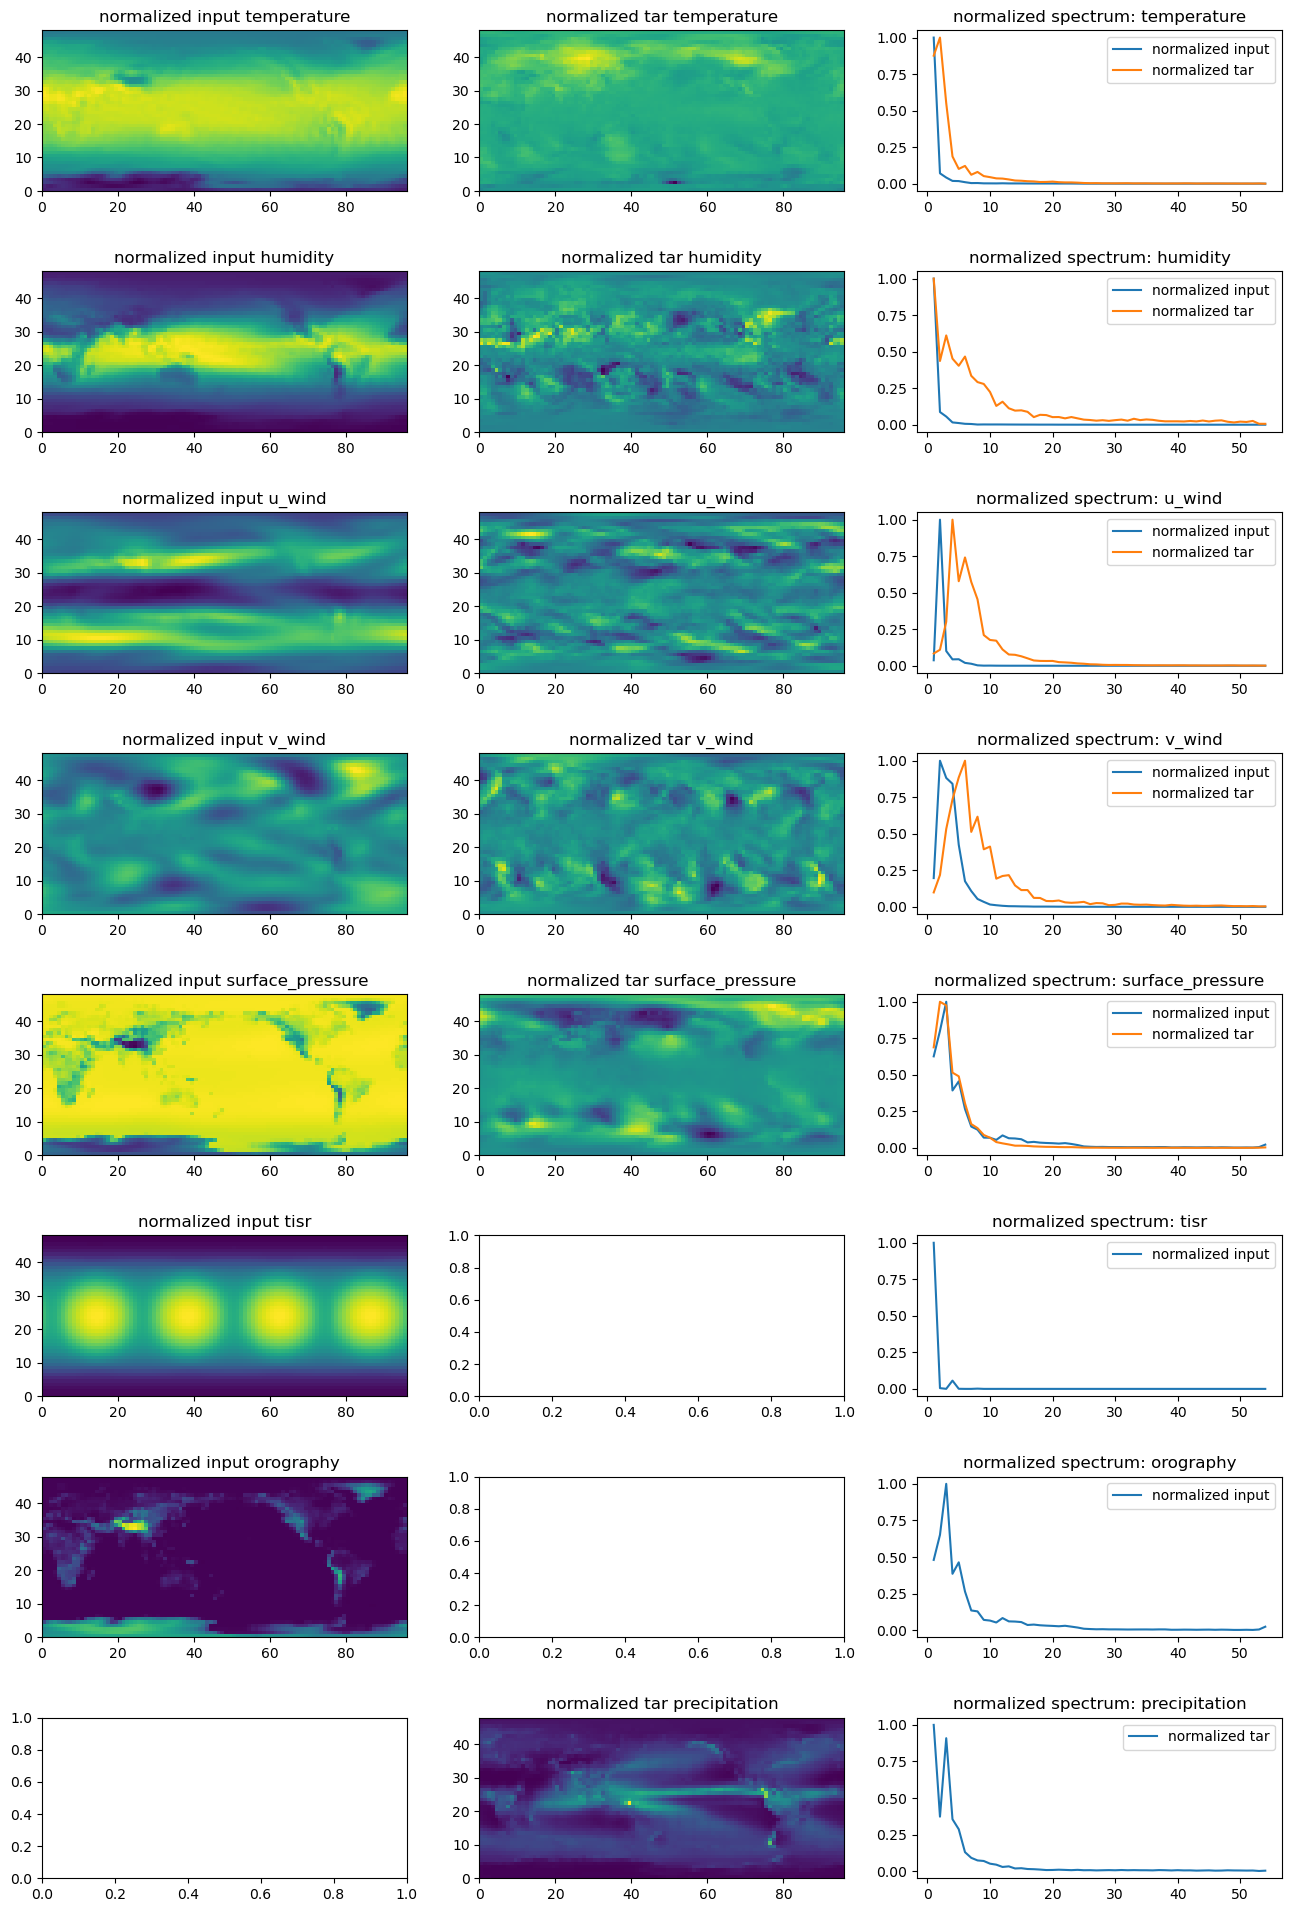

In [12]:
# plot the spatial and spectral pattern of all variable fields
fig, axes = plt.subplots(len(vars_to_plot), 3, figsize=(16, 3 * len(vars_to_plot)))
if len(vars_to_plot) == 1:
    axes = [axes] 

for ii, var in enumerate(vars_to_plot):
    #print(var)
    
    # First column: original 
    if var in inp_vars:
        idx = inp_vars.index(var)
        data_norm0 = data_inp[:,idx,:,:].mean(axis=(0,))
        axes[ii, 0].pcolormesh(data_norm0)
        axes[ii, 0].set_title(f"normalized input {var}")

        ftr = max(*data_norm0.shape)
        kvals0, Abins0 = img2spectrum(data_norm0,ftr)
        axes[ii, 2].plot(kvals0, Abins0/max(Abins0), label="normalized input")

    # Second column: normalized input data
    if var in tar_vars:
        idx = tar_vars.index(var)
        data_norm1 = data_tar[:,idx,:,:].mean(axis=(0,))
        axes[ii, 1].pcolormesh(data_norm1)
        axes[ii, 1].set_title(f"normalized tar {var}")

        ftr = max(*data_norm1.shape)
        kvals1, Abins1 = img2spectrum(data_norm1,ftr)
        axes[ii, 2].plot(kvals1, Abins1/max(Abins1), label="normalized tar")
        
    # third column: normalized output data
    axes[ii, 2].legend()
    axes[ii, 2].set_title(f"normalized spectrum: {var}")
    
plt.subplots_adjust(hspace=0.5)

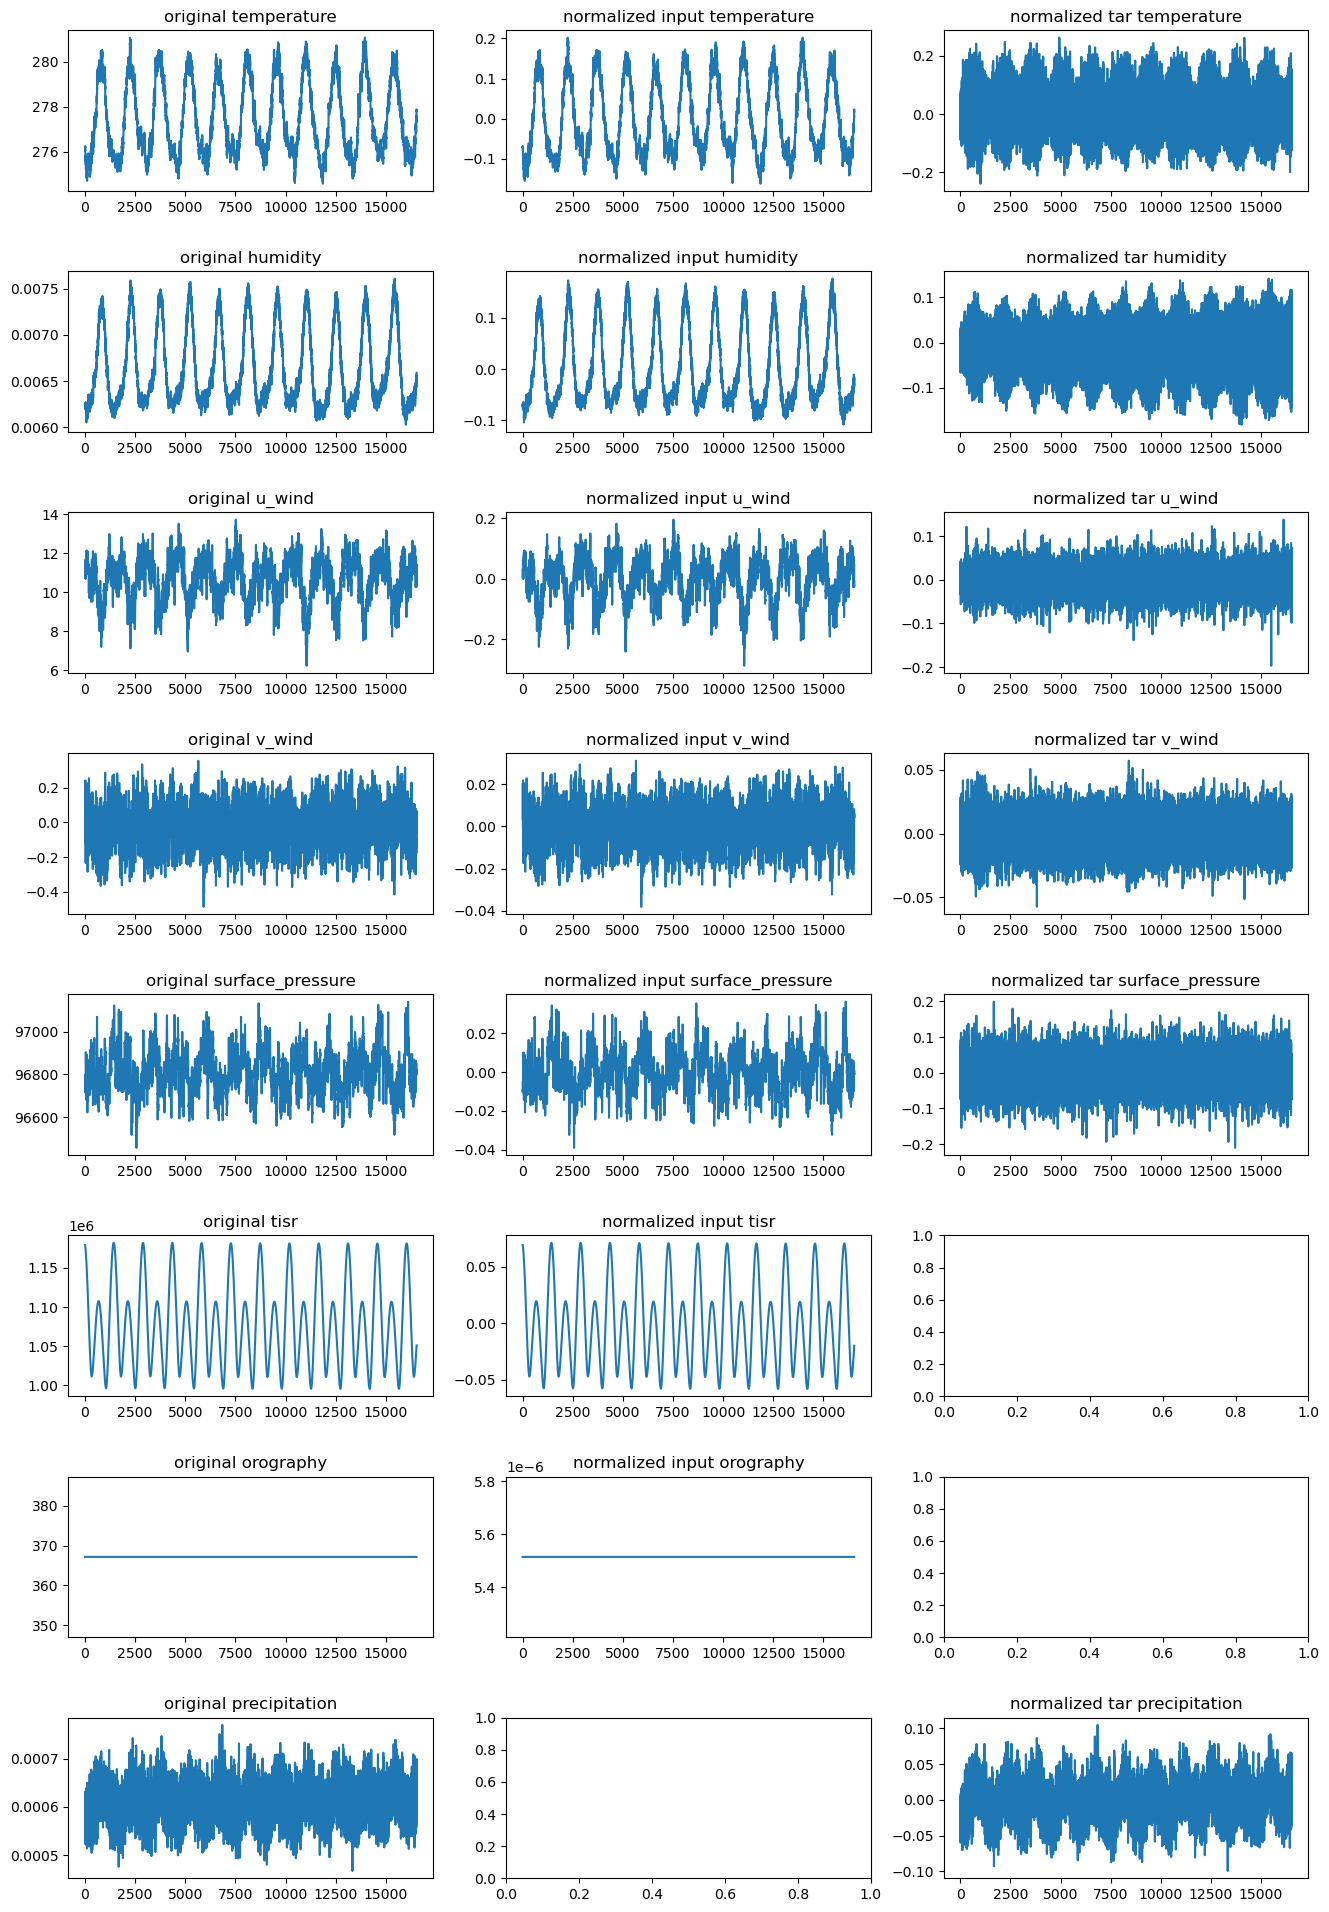

In [13]:
# plot the global mean over time of each variable

fig, axes = plt.subplots(len(vars_to_plot), 3, figsize=(16, 3 * len(vars_to_plot)))
if len(vars_to_plot) == 1:
    axes = [axes] 

for ii, var in enumerate(vars_to_plot):
    #print(var)
    
    # First column: normalized input data
    data = raw_data[var]
    axes[ii, 0].plot(data.mean(axis=(-2,-1)))
    axes[ii, 0].set_title(f"original {var}")

    # Second column: normalized output data
    if var in inp_vars:
        idx = inp_vars.index(var)
        data_norm0 = data_inp[:,idx,:,:].mean(axis=(-2,-1))
        axes[ii, 1].plot(data_norm0)
        axes[ii, 1].set_title(f"normalized input {var}")

    # third column: normalized input vs output data spectrum
    if var in tar_vars:
        idx = tar_vars.index(var)
        data_norm1 = data_tar[:,idx,:,:].mean(axis=(-2,-1))
        axes[ii, 2].plot(data_norm1)
        axes[ii, 2].set_title(f"normalized tar {var}")
    
plt.subplots_adjust(hspace=0.5)

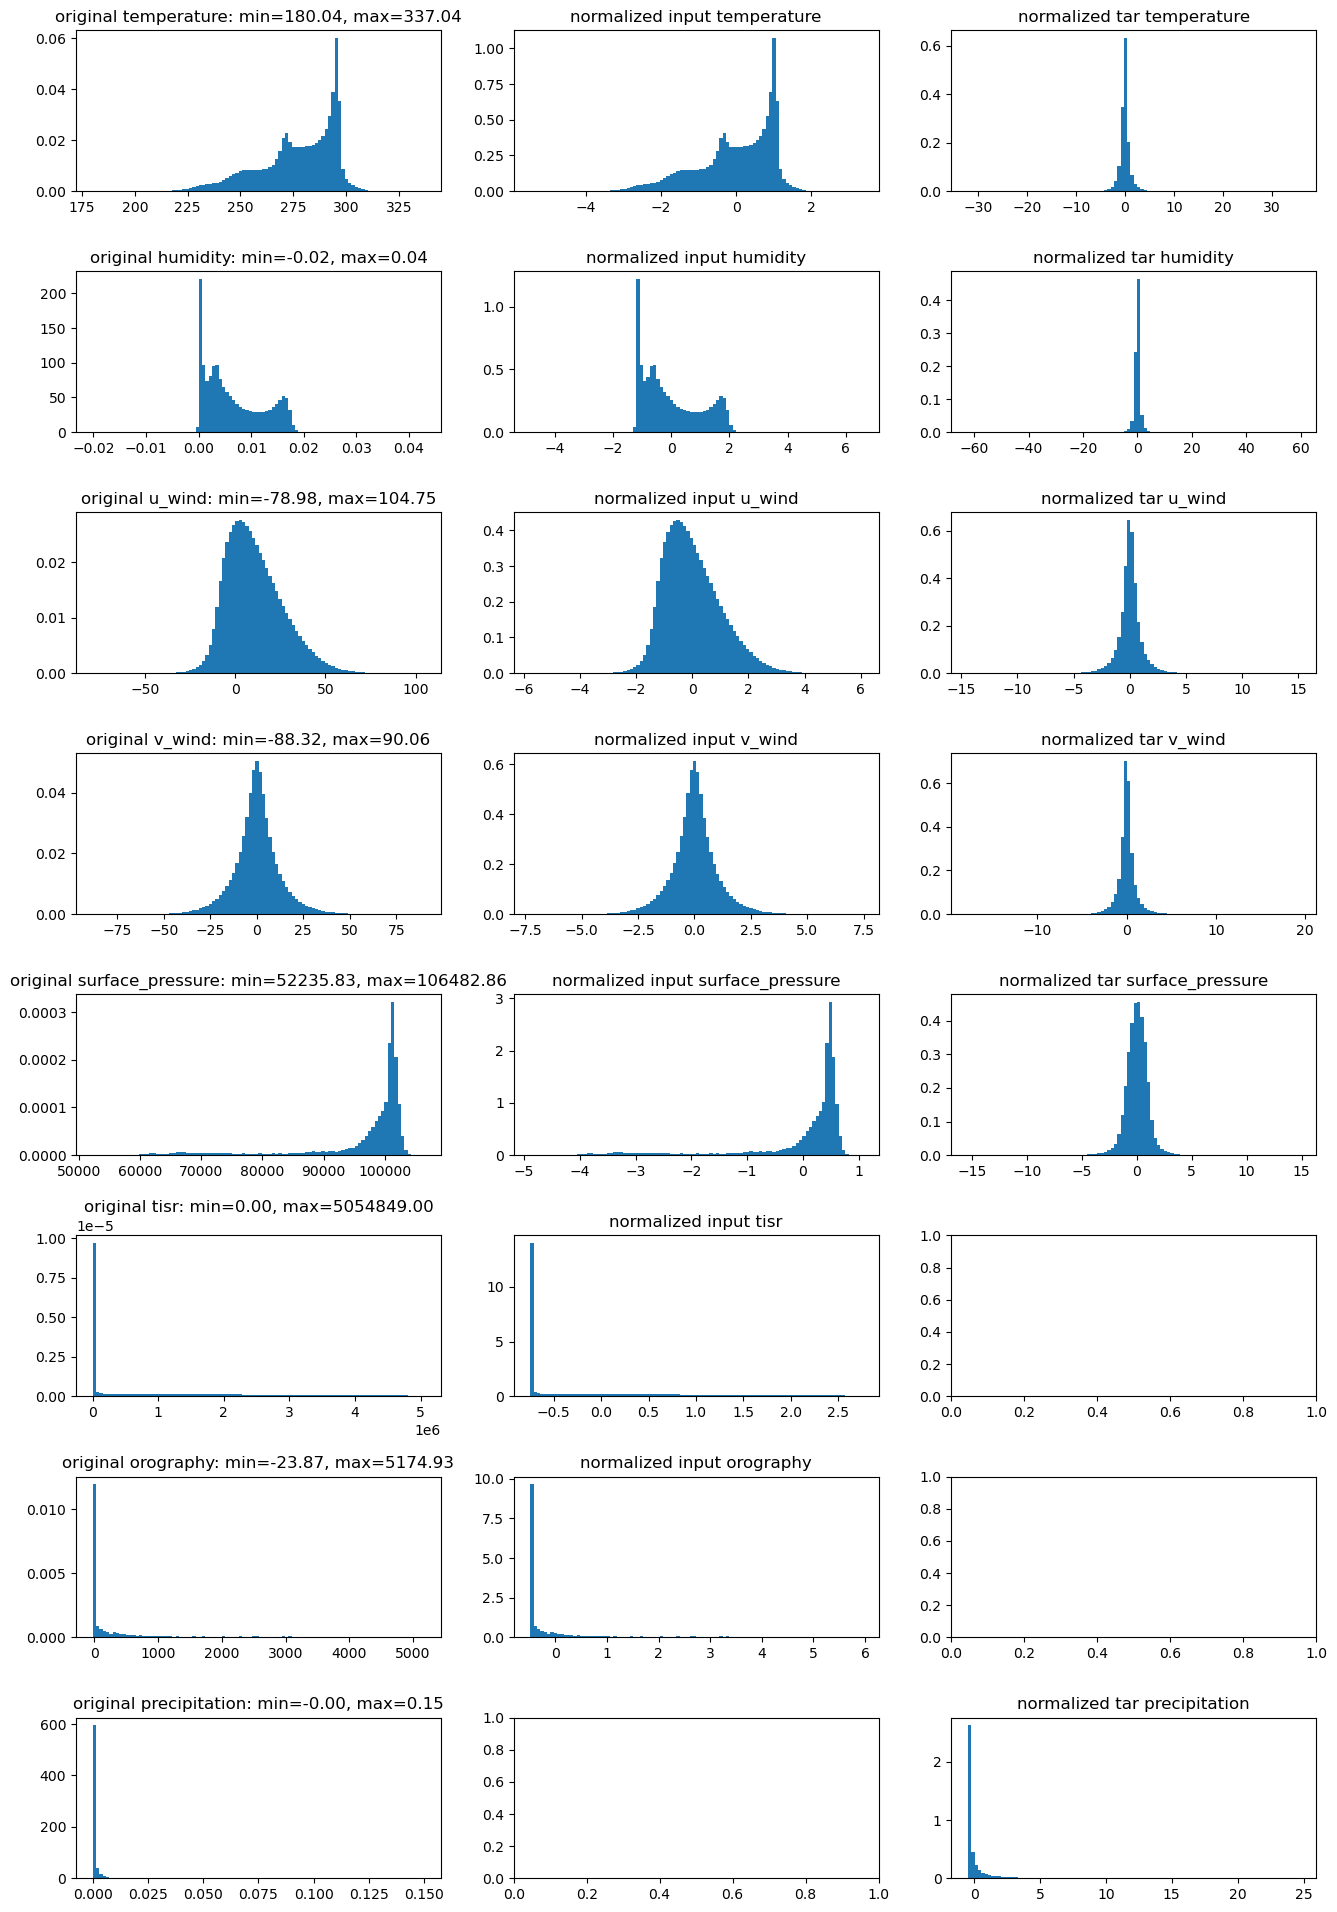

In [14]:
# plot the distribution of all variable fileds

wdir = "/g/data/z00/yxs900/neuraloperators/sfno/curriculum_learning/lowRes/experiments/03_LUCIE/LUCIE_fix"
raw_data = np.load(f"{wdir}/era5_T30_regridded.npz")

data = np.load(f"{wdir}/era5_T30_preprocessed.npz")
data_inp = data["data_inp"]     # input data 
data_tar = data["data_tar"]

inp_vars = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure', 'tisr', 'orography']
tar_vars = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure','precipitation']
vars_to_plot = ['temperature', 'humidity', 'u_wind', 'v_wind', 'surface_pressure', 'tisr', 'orography','precipitation']

fig, axes = plt.subplots(len(vars_to_plot), 3, figsize=(16, 3 * len(vars_to_plot)))
if len(vars_to_plot) == 1:
    axes = [axes] 

for ii, var in enumerate(vars_to_plot):
    #print(var)
    data = raw_data[var]
    data = data[~np.isnan(data)]
    # Compute min, max, 5th and 95th percentiles
    vmin = data.min()
    vmax = data.max()

    # First column: original 
    axes[ii, 0].hist(data, bins=100,density=True)
    axes[ii, 0].set_title(f"original {var}: min={vmin:.2f}, max={vmax:.2f}")

    # Second column: normalized input data
    if var in inp_vars:
        idx = inp_vars.index(var)
        data_norm0 = data_inp[:,idx,:,:].flatten()
        axes[ii, 1].hist(data_norm0, bins=100, density=True)
        axes[ii, 1].set_title(f"normalized input {var}")

    # third column: normalized output data
    if var in tar_vars:
        idx = tar_vars.index(var)
        data_norm1 = data_tar[:,idx,:,:].flatten()
        axes[ii, 2].hist(data_norm1, bins=100, density=True)
        axes[ii, 2].set_title(f"normalized tar {var}")
    
plt.subplots_adjust(hspace=0.5)

# The END